# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

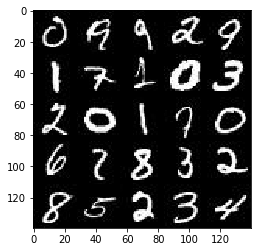

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

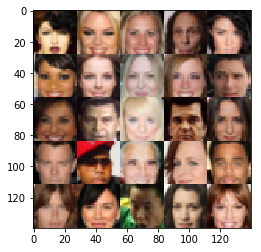

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.09):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn1, bn1)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn2, bn2)

        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.09, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        layer1 = tf.layers.dense(z, 7*7*256)
        
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #dropout1 = tf.nn.dropout(relu1, keep_prob)
        
        layer2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #dropout2 = tf.nn.dropout(relu2, keep_prob)
        
        layer3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #dropout3 = tf.nn.dropout(relu3, keep_prob)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lrn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lrn_rate = learning_rate
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrn_rate, beta1)
    
    step_count =0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                step_count += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if step_count%10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step_count%100 == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1911... Generator Loss: 0.2432
Epoch 1/2... Discriminator Loss: 2.0991... Generator Loss: 0.3877
Epoch 1/2... Discriminator Loss: 2.5468... Generator Loss: 0.1386
Epoch 1/2... Discriminator Loss: 2.1296... Generator Loss: 0.3281
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 1.1372
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 1.6636
Epoch 1/2... Discriminator Loss: 1.8007... Generator Loss: 0.3019
Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 2.0575... Generator Loss: 0.2431


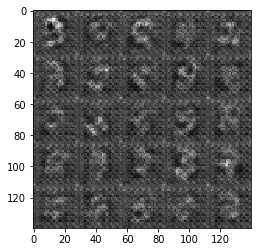

Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.3074
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.3107
Epoch 1/2... Discriminator Loss: 1.8084... Generator Loss: 0.2871
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.9127... Generator Loss: 0.2772
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.9745


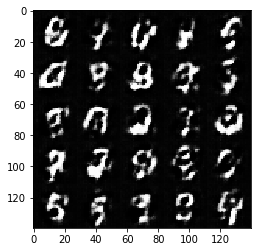

Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.4951
Epoch 1/2... Discriminator Loss: 2.1093... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.2773
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 2.5471
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.6580
Epoch 1/2... Discriminator Loss: 2.3004... Generator Loss: 4.1392
Epoch 1/2... Discriminator Loss: 1.3354... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 1.1915


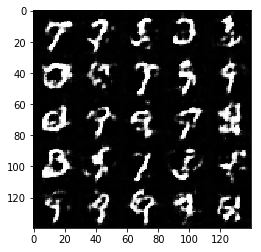

Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 1.6072
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.8956
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 2.0491... Generator Loss: 0.2487
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.8519
Epoch 1/2... Discriminator Loss: 1.7600... Generator Loss: 0.3308
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 2.2787... Generator Loss: 0.1852
Epoch 1/2... Discriminator Loss: 3.0288... Generator Loss: 3.8647
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 1.4894


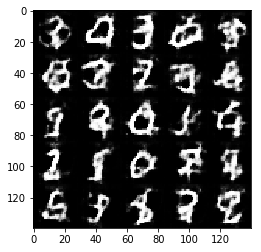

Epoch 1/2... Discriminator Loss: 1.7716... Generator Loss: 0.3427
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 1.5701
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.8321
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 2.2718... Generator Loss: 0.2062
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.4952


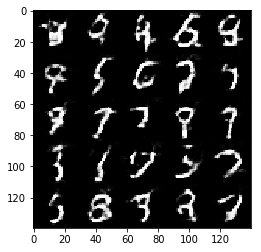

Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.5134
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.3848
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.8858
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 1.0658
Epoch 1/2... Discriminator Loss: 1.5851... Generator Loss: 0.3816


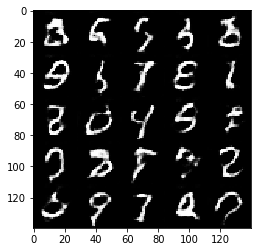

Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.2839
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.4909
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.5595
Epoch 1/2... Discriminator Loss: 2.7551... Generator Loss: 0.1197
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 1.5416
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.3217
Epoch 1/2... Discriminator Loss: 1.8444... Generator Loss: 0.3060
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.5965


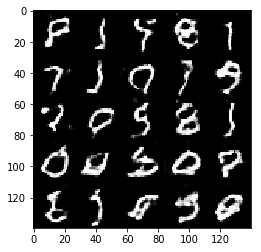

Epoch 1/2... Discriminator Loss: 1.5391... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 1.4932
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.2560
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.6637
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.4504
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 0.9357
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 0.7494


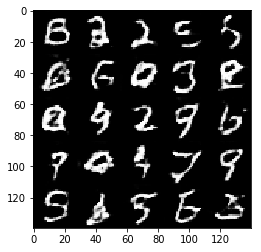

Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 0.8579... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.3398
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 1.0193
Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.9575


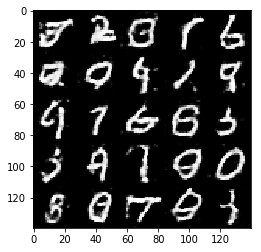

Epoch 1/2... Discriminator Loss: 2.1158... Generator Loss: 0.2346
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 0.9494... Generator Loss: 1.7232
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.6864
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 1.0146... Generator Loss: 1.6126
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.6504


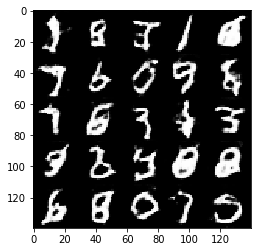

Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.2336
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 0.9689
Epoch 1/2... Discriminator Loss: 0.7586... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.2939
Epoch 1/2... Discriminator Loss: 1.1550... Generator Loss: 0.6940


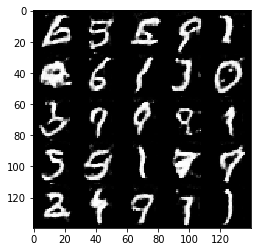

Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.3922
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.4673
Epoch 1/2... Discriminator Loss: 2.0136... Generator Loss: 0.2877
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.5694
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 1.5410
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.5117


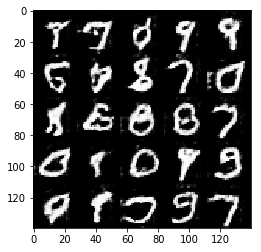

Epoch 1/2... Discriminator Loss: 0.9371... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 3.1329... Generator Loss: 3.0376
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 1.2599
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 1.8212... Generator Loss: 0.3367
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 2.5860... Generator Loss: 3.5748


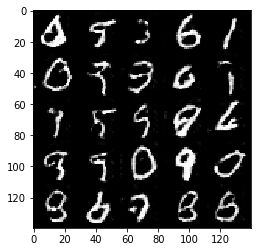

Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 0.9443
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 0.9046... Generator Loss: 1.0132


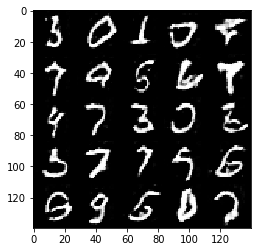

Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 0.8159... Generator Loss: 1.1631
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.1035
Epoch 1/2... Discriminator Loss: 2.6663... Generator Loss: 0.1521
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.0983
Epoch 1/2... Discriminator Loss: 1.2537... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 2.1442... Generator Loss: 0.2672
Epoch 1/2... Discriminator Loss: 1.5000... Generator Loss: 0.4934


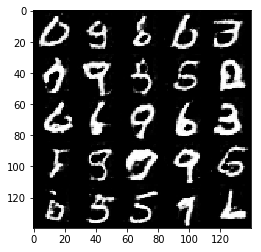

Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.6813... Generator Loss: 2.5478
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.4928
Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 1.7936
Epoch 1/2... Discriminator Loss: 1.0011... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 2.4449
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.5029


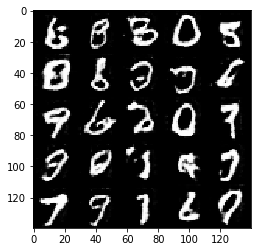

Epoch 1/2... Discriminator Loss: 1.7402... Generator Loss: 0.3664
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 2.5744
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 0.9001
Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.5768
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7933
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.2093


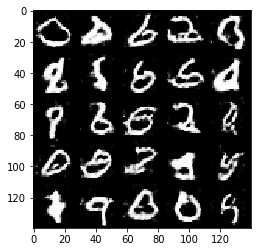

Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.4871
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.1024
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 1.6320
Epoch 1/2... Discriminator Loss: 1.6793... Generator Loss: 0.3853
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 1.0546


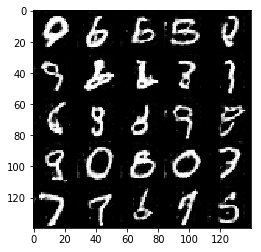

Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.1283
Epoch 1/2... Discriminator Loss: 1.4976... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.7609... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 2.3606... Generator Loss: 3.0552
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 1.1697
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.5608
Epoch 2/2... Discriminator Loss: 1.5445... Generator Loss: 0.4539
Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 0.6905


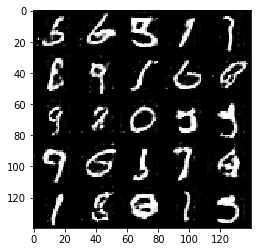

Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 1.4876... Generator Loss: 0.4929
Epoch 2/2... Discriminator Loss: 1.9788... Generator Loss: 0.2546
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.8725
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.5236
Epoch 2/2... Discriminator Loss: 1.3605... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.7245
Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.3664
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.7478


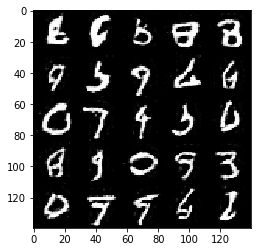

Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 3.0798
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.2615
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 1.6862
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.3769
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 1.4092
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 0.9247
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 1.5179
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.5620


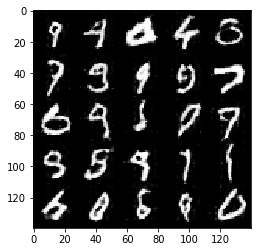

Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.5681
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 2.5760
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 1.5694... Generator Loss: 0.4100
Epoch 2/2... Discriminator Loss: 1.6300... Generator Loss: 0.9043
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 1.2691
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.5539
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.3750


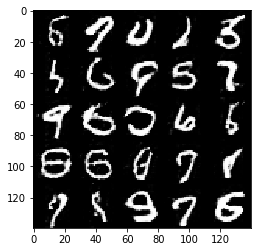

Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.9656
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.3139
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.3753
Epoch 2/2... Discriminator Loss: 1.5170... Generator Loss: 0.4896
Epoch 2/2... Discriminator Loss: 1.7563... Generator Loss: 0.3472
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.7082... Generator Loss: 2.4722
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.7236


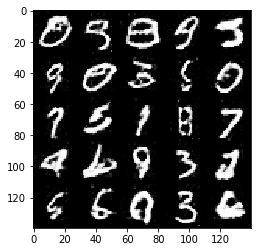

Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.6391
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.5044... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 0.9635... Generator Loss: 1.2738
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.5354


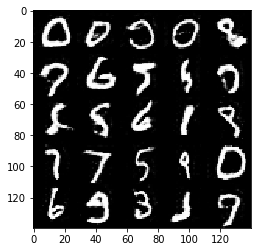

Epoch 2/2... Discriminator Loss: 1.7584... Generator Loss: 1.9607
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 1.6059
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.5804
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.5626
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 2.0281
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 0.9771
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.1222


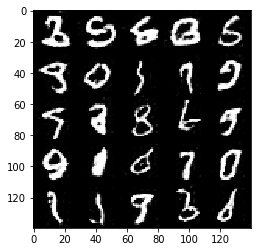

Epoch 2/2... Discriminator Loss: 1.8406... Generator Loss: 0.3972
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6839
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.9444
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 0.7267
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.4614
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 1.1402
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.4867
Epoch 2/2... Discriminator Loss: 1.6299... Generator Loss: 0.3786
Epoch 2/2... Discriminator Loss: 1.8183... Generator Loss: 0.3333


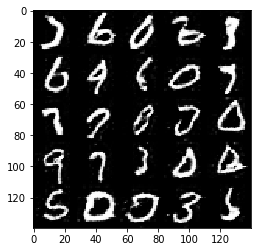

Epoch 2/2... Discriminator Loss: 0.9433... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 1.8534
Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 2.0365... Generator Loss: 0.3381
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.7381


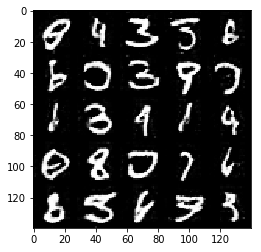

Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.9951
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 2.3416
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.6177
Epoch 2/2... Discriminator Loss: 1.0986... Generator Loss: 0.8675


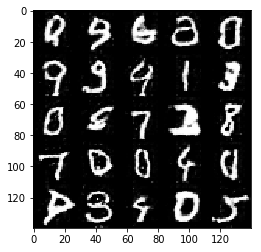

Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.1169
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.8155
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.4129
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.8549
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.8391... Generator Loss: 0.3064


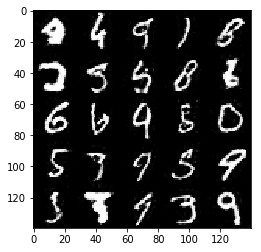

Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.0470
Epoch 2/2... Discriminator Loss: 1.8326... Generator Loss: 2.2020
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.5100
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 2.0277
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.1185


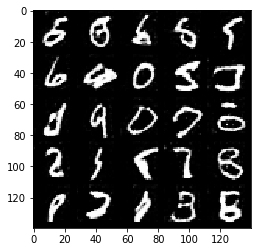

Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.3409
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.6301
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 2.0695
Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 3.2796
Epoch 2/2... Discriminator Loss: 0.9311... Generator Loss: 2.4136
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.1580


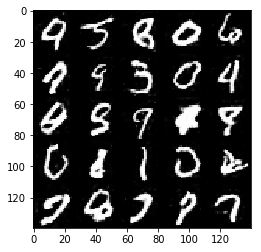

Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.6486
Epoch 2/2... Discriminator Loss: 1.7506... Generator Loss: 0.3811
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.0720
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.9329... Generator Loss: 0.2922
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 2.0544... Generator Loss: 0.2631
Epoch 2/2... Discriminator Loss: 1.5270... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 0.9048


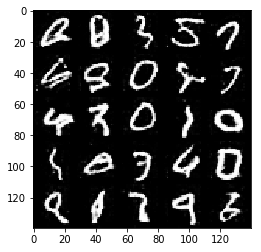

Epoch 2/2... Discriminator Loss: 1.0686... Generator Loss: 1.0869
Epoch 2/2... Discriminator Loss: 1.0000... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 1.7267... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 1.0263
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.2140... Generator Loss: 0.6770


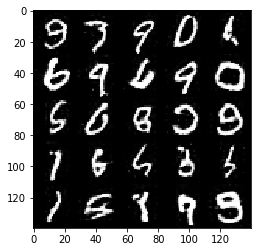

Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 1.2065
Epoch 2/2... Discriminator Loss: 2.0886... Generator Loss: 0.2642
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.3523
Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.5294
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.5142
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.5101... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.5827


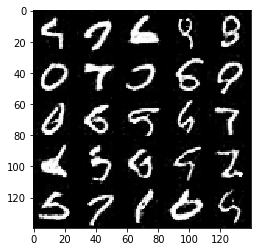

Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 0.8553
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 1.2022... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.5628
Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.4980


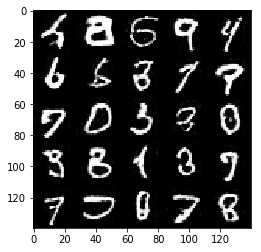

Epoch 2/2... Discriminator Loss: 1.8668... Generator Loss: 0.3409
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.8463
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 0.7550... Generator Loss: 1.9764
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 1.7051... Generator Loss: 0.4055
Epoch 2/2... Discriminator Loss: 1.5104... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 0.9513


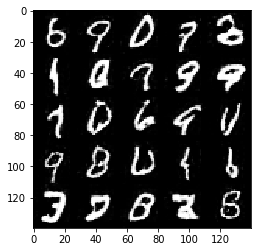

Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 1.3474
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 2.1135
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 0.9636... Generator Loss: 1.0350
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.8428
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 2.0708... Generator Loss: 0.2994


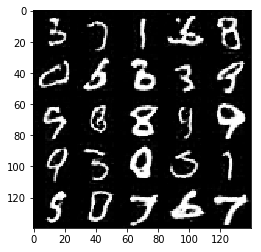

Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 2.6492
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.9546


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2733... Generator Loss: 0.0676
Epoch 1/1... Discriminator Loss: 2.8706... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 3.1168
Epoch 1/1... Discriminator Loss: 2.5448... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.1493


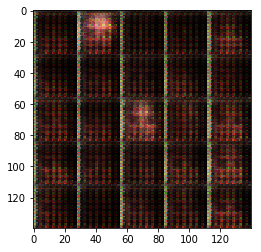

Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 2.2080
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.7628


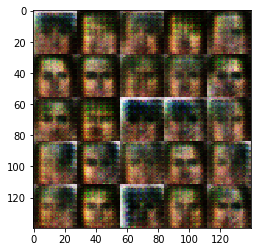

Epoch 1/1... Discriminator Loss: 2.2526... Generator Loss: 0.2352
Epoch 1/1... Discriminator Loss: 2.0794... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 2.1735... Generator Loss: 0.2215
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 1.1334


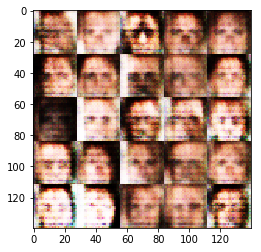

Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 2.2254... Generator Loss: 0.2091
Epoch 1/1... Discriminator Loss: 1.8325... Generator Loss: 0.3514
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.9352


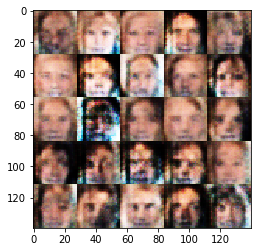

Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.7136... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.8543... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.9287... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.6474... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.7559


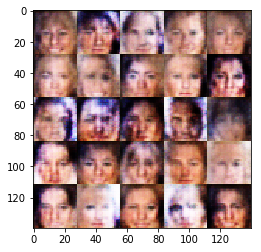

Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.7167... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.7410... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.4851


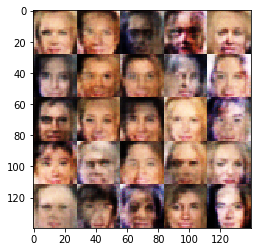

Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.9874... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.8012


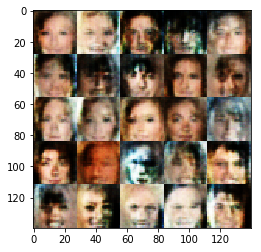

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.8509... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.6692


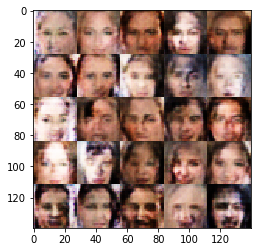

Epoch 1/1... Discriminator Loss: 1.6941... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.7263... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.5215


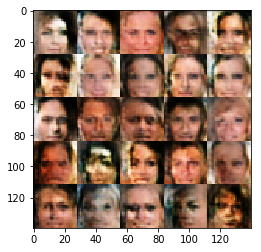

Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.7295... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.7046... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.7406... Generator Loss: 0.4718


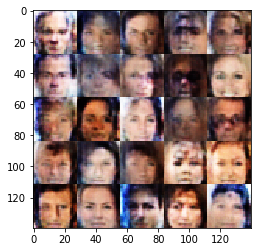

Epoch 1/1... Discriminator Loss: 1.8745... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5948... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.8624... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.6973... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.7272... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 1.8927... Generator Loss: 0.2743
Epoch 1/1... Discriminator Loss: 1.7563... Generator Loss: 0.3396


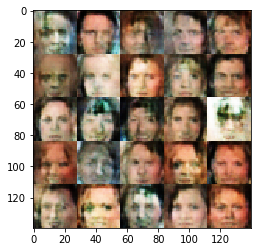

Epoch 1/1... Discriminator Loss: 1.7576... Generator Loss: 0.4178
Epoch 1/1... Discriminator Loss: 1.8909... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.4234
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.7484... Generator Loss: 0.4451


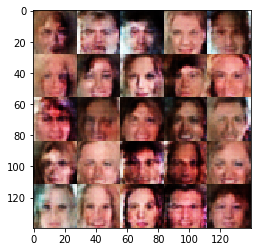

Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.7911... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.7378... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.5241


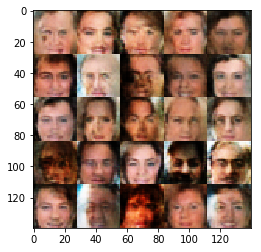

Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.6874... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 2.0725... Generator Loss: 0.2177
Epoch 1/1... Discriminator Loss: 1.7015... Generator Loss: 0.4233


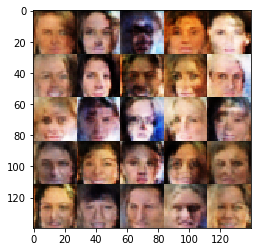

Epoch 1/1... Discriminator Loss: 1.7926... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.7526... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6089


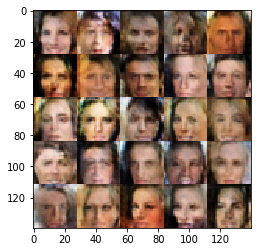

Epoch 1/1... Discriminator Loss: 1.7697... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.9397... Generator Loss: 0.2996


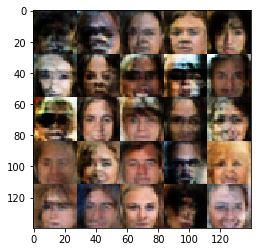

Epoch 1/1... Discriminator Loss: 1.8889... Generator Loss: 0.2703
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.8103... Generator Loss: 0.3084
Epoch 1/1... Discriminator Loss: 1.7378... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.4259


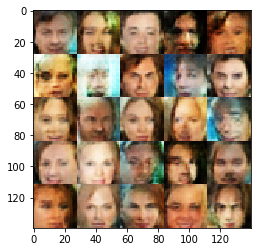

Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 2.0534... Generator Loss: 0.2722
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.6912


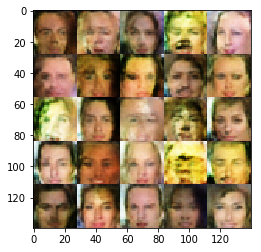

Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 1.6761... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.7445... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 2.0692... Generator Loss: 0.2510
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.5044


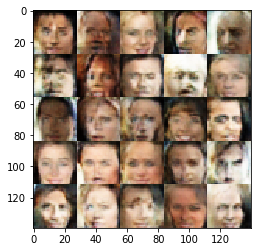

Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.6787... Generator Loss: 0.4417
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.7457... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.6428... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 2.0170... Generator Loss: 0.2613


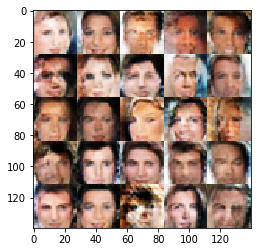

Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.7359... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.4884


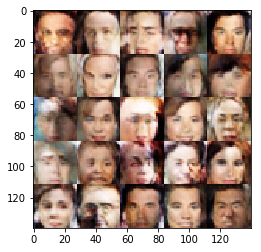

Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.6994... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 1.8993... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.7540... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 1.9697... Generator Loss: 0.2896
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.4420


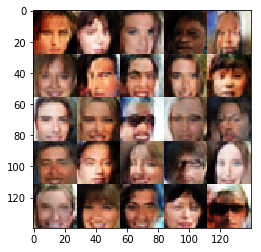

Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 1.8246... Generator Loss: 0.3352
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.8182... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.4565
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7601


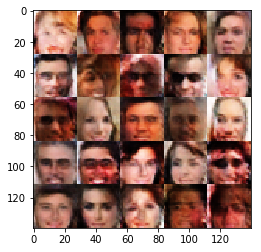

Epoch 1/1... Discriminator Loss: 2.0090... Generator Loss: 0.3797
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.2949
Epoch 1/1... Discriminator Loss: 1.8667... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.5021


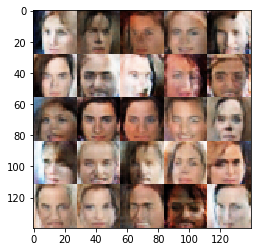

Epoch 1/1... Discriminator Loss: 2.1117... Generator Loss: 0.2039
Epoch 1/1... Discriminator Loss: 1.9551... Generator Loss: 0.3725
Epoch 1/1... Discriminator Loss: 1.9886... Generator Loss: 0.2918
Epoch 1/1... Discriminator Loss: 1.9222... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.7713... Generator Loss: 0.3792
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.5126


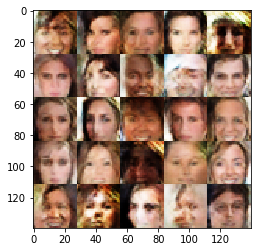

Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.6669... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.7261... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 1.8386... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 0.3364
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.4319


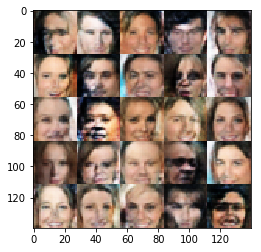

Epoch 1/1... Discriminator Loss: 1.6812... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.9070... Generator Loss: 0.2938
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.8113... Generator Loss: 0.3277
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.8305... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 2.0854... Generator Loss: 0.2205


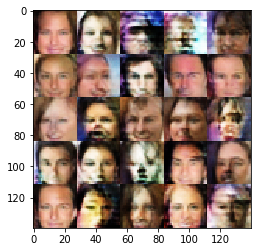

Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.7589... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.7145... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.9851... Generator Loss: 0.2715
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.6739... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.9171... Generator Loss: 0.3632


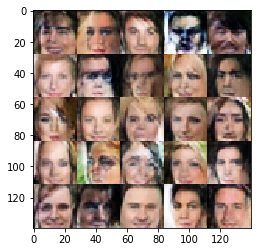

Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 1.7840... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.9951... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.8817... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5925


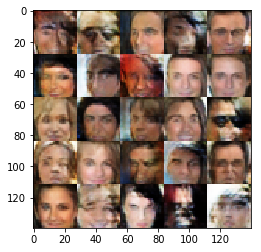

Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 1.9304... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.3306
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 2.0834... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.6476... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.7666... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 1.8291... Generator Loss: 0.3514
Epoch 1/1... Discriminator Loss: 1.8805... Generator Loss: 0.3143


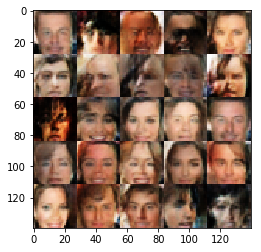

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.7433... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.8096... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.3130


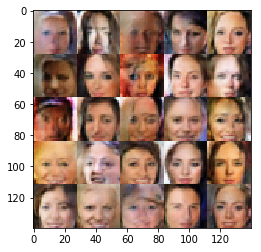

Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.6776... Generator Loss: 0.3745
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.8167... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.4263


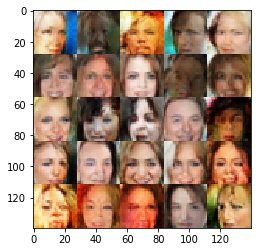

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.3604
Epoch 1/1... Discriminator Loss: 1.9255... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 1.8198... Generator Loss: 0.2883
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.6920... Generator Loss: 0.5472


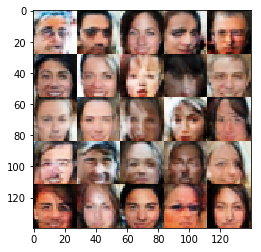

Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.7989... Generator Loss: 0.3607
Epoch 1/1... Discriminator Loss: 1.7787... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.7258... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6923


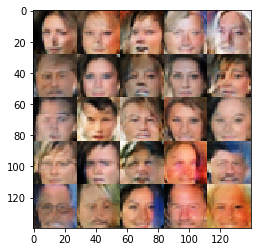

Epoch 1/1... Discriminator Loss: 1.7525... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.8737... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.5001


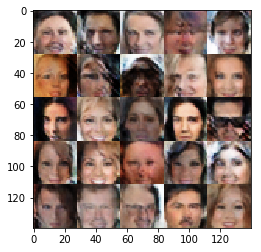

Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 2.3133... Generator Loss: 0.1917
Epoch 1/1... Discriminator Loss: 1.7791... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.8368... Generator Loss: 0.3220
Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 0.4594


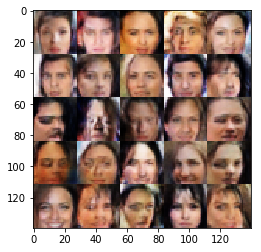

Epoch 1/1... Discriminator Loss: 1.8779... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 1.9936... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.9865... Generator Loss: 0.2772
Epoch 1/1... Discriminator Loss: 1.9740... Generator Loss: 0.2865
Epoch 1/1... Discriminator Loss: 1.8660... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 2.0836... Generator Loss: 0.2747


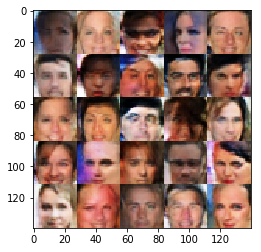

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.7739... Generator Loss: 0.4451
Epoch 1/1... Discriminator Loss: 2.0361... Generator Loss: 0.2628
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 1.7972... Generator Loss: 0.3535


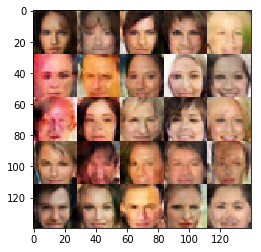

Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 2.1726... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 2.0887... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.8027... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.8874... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 1.6935... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.8926... Generator Loss: 0.2804


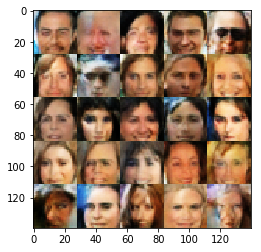

Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.3948
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.6671... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.7047... Generator Loss: 0.4468
Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.7601... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5451


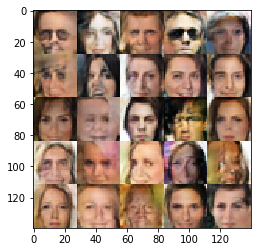

Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.8331... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.4823


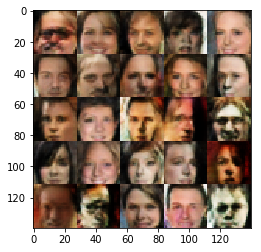

Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.9438... Generator Loss: 0.2847
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.6864... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.8495... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.7692... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8464


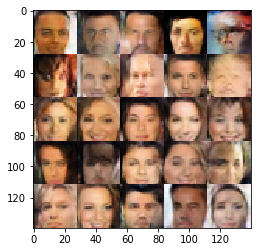

Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 2.0319... Generator Loss: 0.2358
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.7562... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.8543... Generator Loss: 0.2807
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.4690


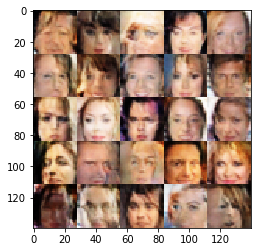

Epoch 1/1... Discriminator Loss: 2.1765... Generator Loss: 0.1950
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.6824... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.8152... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.3145


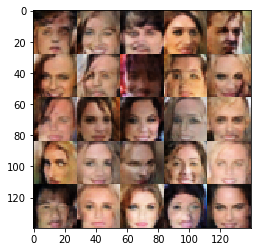

Epoch 1/1... Discriminator Loss: 2.0403... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.8666... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 2.0139... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.3577
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.3620


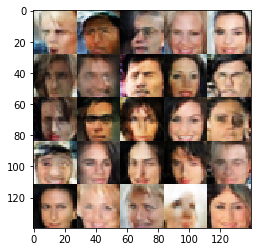

Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.7790... Generator Loss: 0.3990
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 1.2667
Epoch 1/1... Discriminator Loss: 1.6366... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.6696... Generator Loss: 0.4010
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.9928... Generator Loss: 0.2791


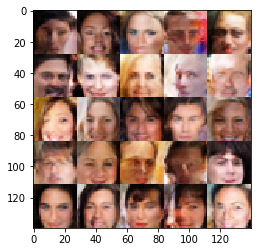

Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.9634... Generator Loss: 0.2456
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 2.1067... Generator Loss: 0.2159
Epoch 1/1... Discriminator Loss: 1.9874... Generator Loss: 0.2514
Epoch 1/1... Discriminator Loss: 2.0685... Generator Loss: 0.2186
Epoch 1/1... Discriminator Loss: 1.7891... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 2.1120... Generator Loss: 0.2184
Epoch 1/1... Discriminator Loss: 1.7467... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.4471


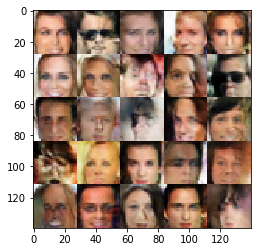

Epoch 1/1... Discriminator Loss: 2.4332... Generator Loss: 0.1486
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 2.0745... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 1.5776... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.6746... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 1.7261... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 1.7065... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 2.2056... Generator Loss: 0.1808
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.3697


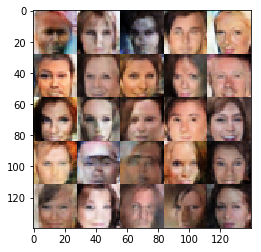

Epoch 1/1... Discriminator Loss: 1.9363... Generator Loss: 0.2402
Epoch 1/1... Discriminator Loss: 1.8877... Generator Loss: 0.2700
Epoch 1/1... Discriminator Loss: 1.8627... Generator Loss: 0.3012
Epoch 1/1... Discriminator Loss: 1.7503... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 2.3137... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 2.0099... Generator Loss: 0.2346
Epoch 1/1... Discriminator Loss: 1.7732... Generator Loss: 0.2924
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 2.0538... Generator Loss: 0.2302


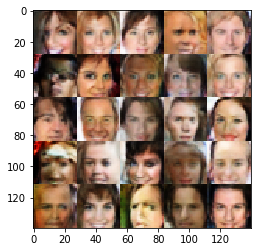

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.7796... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 2.2795... Generator Loss: 0.1911
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.4850


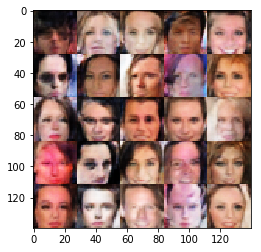

Epoch 1/1... Discriminator Loss: 2.1850... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 1.9034... Generator Loss: 0.2944
Epoch 1/1... Discriminator Loss: 1.9015... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.8486... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 2.3107... Generator Loss: 0.1726
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 2.3762... Generator Loss: 0.1502


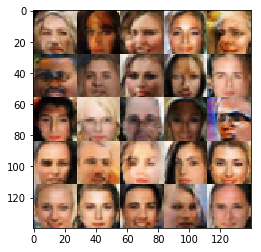

Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 2.2328... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.8591... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 1.8707... Generator Loss: 0.2849
Epoch 1/1... Discriminator Loss: 1.9988... Generator Loss: 0.2644
Epoch 1/1... Discriminator Loss: 1.8647... Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9438


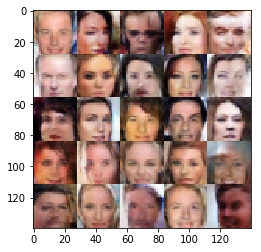

Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.8712... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 1.7734... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.2587
Epoch 1/1... Discriminator Loss: 1.9886... Generator Loss: 0.2490
Epoch 1/1... Discriminator Loss: 1.9226... Generator Loss: 0.2952
Epoch 1/1... Discriminator Loss: 1.9370... Generator Loss: 0.3402
Epoch 1/1... Discriminator Loss: 1.7111... Generator Loss: 0.3813


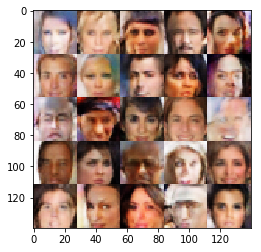

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 2.1474... Generator Loss: 0.2154
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.2234
Epoch 1/1... Discriminator Loss: 1.9691... Generator Loss: 0.2466
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 2.2719... Generator Loss: 0.1792


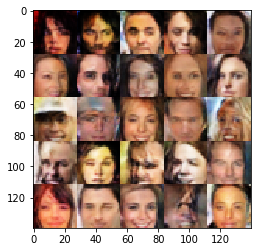

Epoch 1/1... Discriminator Loss: 1.9367... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.8256... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.8798... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 2.7069... Generator Loss: 0.1362
Epoch 1/1... Discriminator Loss: 1.8794... Generator Loss: 0.2750
Epoch 1/1... Discriminator Loss: 1.9184... Generator Loss: 0.2433
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.4847


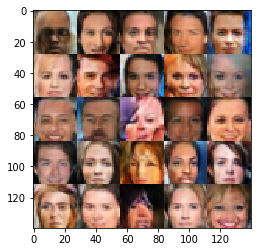

Epoch 1/1... Discriminator Loss: 1.7590... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.6469... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.8427... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.8966... Generator Loss: 0.2745


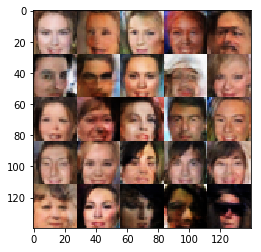

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.7925... Generator Loss: 0.3480
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 2.0672... Generator Loss: 0.2274
Epoch 1/1... Discriminator Loss: 1.8471... Generator Loss: 0.2902
Epoch 1/1... Discriminator Loss: 2.0988... Generator Loss: 0.2631
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.9386... Generator Loss: 0.2535


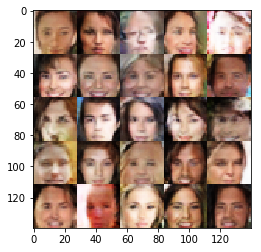

Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.6730... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 1.6586... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.7812... Generator Loss: 0.3103
Epoch 1/1... Discriminator Loss: 1.8504... Generator Loss: 0.2882
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.4908


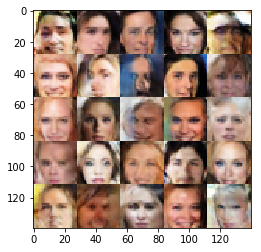

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 2.0447... Generator Loss: 0.2403
Epoch 1/1... Discriminator Loss: 1.9125... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 1.9629... Generator Loss: 0.2523
Epoch 1/1... Discriminator Loss: 2.3982... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 2.3981... Generator Loss: 0.1790
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.8739... Generator Loss: 0.2912
Epoch 1/1... Discriminator Loss: 1.9191... Generator Loss: 0.3000


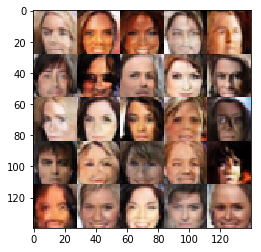

Epoch 1/1... Discriminator Loss: 2.1564... Generator Loss: 0.2058
Epoch 1/1... Discriminator Loss: 2.0607... Generator Loss: 0.2292
Epoch 1/1... Discriminator Loss: 2.3238... Generator Loss: 0.1733
Epoch 1/1... Discriminator Loss: 1.8330... Generator Loss: 0.2928
Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.3097
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 2.1990
Epoch 1/1... Discriminator Loss: 2.2548... Generator Loss: 0.1866
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 1.9474


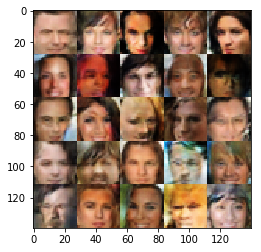

Epoch 1/1... Discriminator Loss: 2.1820... Generator Loss: 0.2089
Epoch 1/1... Discriminator Loss: 2.1138... Generator Loss: 0.2262
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 1.7639... Generator Loss: 0.3066
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 2.1243
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.7633... Generator Loss: 0.3258
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.6021


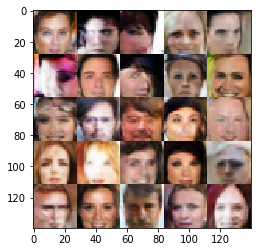

Epoch 1/1... Discriminator Loss: 2.0624... Generator Loss: 0.2231
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 2.0993... Generator Loss: 0.2242
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.9241... Generator Loss: 0.2654
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.9273... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 1.7635... Generator Loss: 0.3447


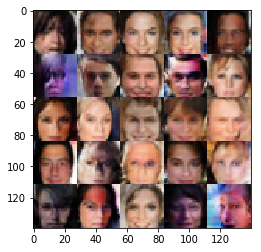

Epoch 1/1... Discriminator Loss: 2.4297... Generator Loss: 0.1565
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.2788
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.9175... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.2267


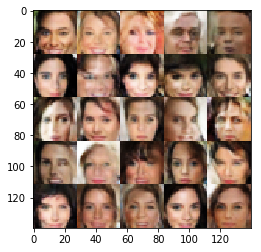

Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.9181... Generator Loss: 0.2680
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.4821


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.